# Initial Setup
To begin the analysis, we first install the required Python packages. The `pbxplore` library is essential for protein backbone analysis, while `svg_stack` enables manipulation and combining of SVG files for visualization purposes. These packages are installed using pip:

In [28]:
! pip install pbxplore svg_stack

  Using cached svg_stack-0.1.0-py3-none-any.whl


In [21]:
# Import libraries 
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
from menger.analysis.mengercurvature import MengerCurvature
from menger.tests.utils import make_universe
from menger.data import  files
import pbxplore as pbx
from PIL import Image


## Loading data

The data of the small MD with only tubulin chaine A is loaded from the menger test module 

In [5]:
# generate data for tubulin dimer
md_name = "tubulin_chain_a"
u = make_universe(
    topology_name=f"{md_name}.pdb",
    trajectory_name=f"{md_name}.dcd",
 )
menger_anlyser= MengerCurvature(u,select="name CA",spacing=2)
menger_anlyser.run()

/home/etienne-reboul/anaconda3/envs/Menger_Curvature/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [ ]:
# retrieve results
local_curbatures = menger_anlyser.results.local_curvatures
local_flexibilities = menger_anlyser.results.local_flexibilities


In [11]:
from MDAnalysis.analysis import rms,align

# Calculate average structure and align
average = align.AverageStructure(u, u, select='protein and name CA',
                                ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref,
                        select='protein and name CA',
                        in_memory=True).run()
# Create RMSF analyzer for CA atoms (same selection as used in MengerCurvature)
rmsf_analyzer = rms.RMSF(u.select_atoms('name CA'))

# Run RMSF calculation
rmsf_analyzer.run()

# Get RMSF values
rmsf = rmsf_analyzer.results.rmsf

/home/etienne-reboul/anaconda3/envs/Menger_Curvature/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [22]:
sequences = []
for chain_name, chain in pbx.chains_from_trajectory(files.TUBULIN_CHAIN_A_DCD, files.TUBULIN_CHAIN_A_PDB):
    dihedrals = chain.get_phi_psi_angles()
    pb_seq = pbx.assign(dihedrals)
    sequences.append(pb_seq)

count_matrix = pbx.analysis.count_matrix(sequences)
neq_by_position = pbx.analysis.compute_neq(count_matrix)

/home/etienne-reboul/anaconda3/envs/Menger_Curvature/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
Frame 1/1000.
Frame 100/1000.
Frame 200/1000.
Frame 300/1000.
Frame 400/1000.
Frame 500/1000.
Frame 600/1000.
Frame 700/1000.
Frame 800/1000.
Frame 900/1000.
Frame 1000/1000.
Frame 1000/1000.


In [31]:
# Common parameters 

number_first_residue = 1
number_last_residue = 450

spacing = 2
size_figure_tuple = (20,7)

ylim_min = 0

xlabel = "Residues of tubulin βIII"
size_xlabel = 25
size_ylabel = 25
size_xticks = 15 
size_yticks = 15
linewidth = 4
size_scatter = 50
alpha_line = 0.6
DPI = 300

In [32]:
# Create a range to plot
range_residues = range(number_first_residue, number_last_residue + 1)

In [33]:
# Parameters for plot LCs
color = "black"
ylim_max = 0.35
ylabel = "Local Curvatures ($Å^{⁻1}$)"

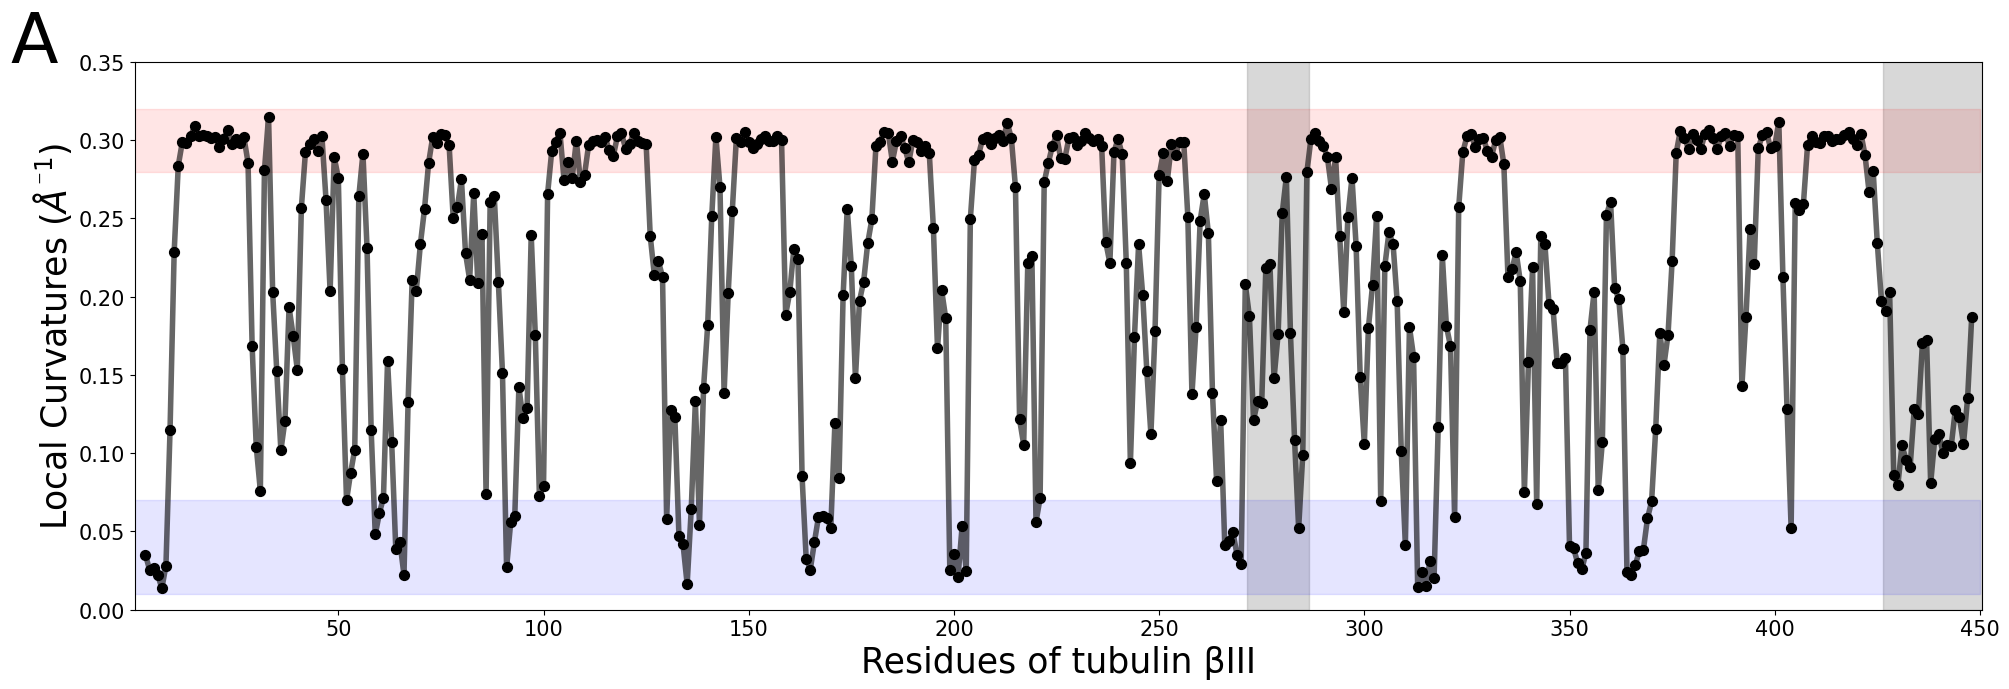

In [36]:
# Plot LCs
plt.figure(figsize=size_figure_tuple)
ax = plt.axes()

plt.xlim(number_first_residue - 0.5, number_last_residue + 0.5)
plt.ylim(ylim_min, ylim_max)

plt.xlabel(xlabel, fontsize=size_xlabel)
plt.ylabel(ylabel, fontsize=size_ylabel)

# Add rectangles where the flexible parts are 
rect_M_loop = patches.Rectangle((271.5, 0), 15, 0.36, color='grey', alpha=0.3) # Residues 272 to 286
rect_CTT = patches.Rectangle((426.5, 0), 25, 0.36, color='grey', alpha=0.3) # Residues 427 to 450

ax.add_patch(rect_M_loop)
ax.add_patch(rect_CTT)


# Add filling for the zones usually occupied by alpha-helices and beta-sheets
plt.fill_between(x=range(0,451), y1=0.01, y2=0.07, color="blue", alpha=0.1) # beta-sheets
plt.fill_between(x=range(0,451), y1=0.28, y2=0.32, color="red", alpha=0.1) # alpha-helices

# Plot curvature data
plt.scatter(range_residues[spacing:-spacing], local_curbatures, color=color, s=size_scatter, label='LCs')
plt.plot(range_residues[spacing:-spacing], local_curbatures, color=color, linewidth=linewidth, alpha=alpha_line)


plt.xticks(fontsize=size_xticks)
plt.yticks(fontsize=size_yticks)

# Indicate that this is Figure A
plt.text(-30, 0.35,"A", fontsize=50)

plt.tight_layout()

plt.savefig("../figures/LCs.svg", dpi=DPI)

In [37]:
# Parameters for the plot of comparison of LFs, Neq and RMSF
color_LFs = "black"
color_Neq = "blue"
color_RMSF = "red"
ylim_max = 0.10
ylabel = "Local Flexibilities ($Å^{⁻1}$)"

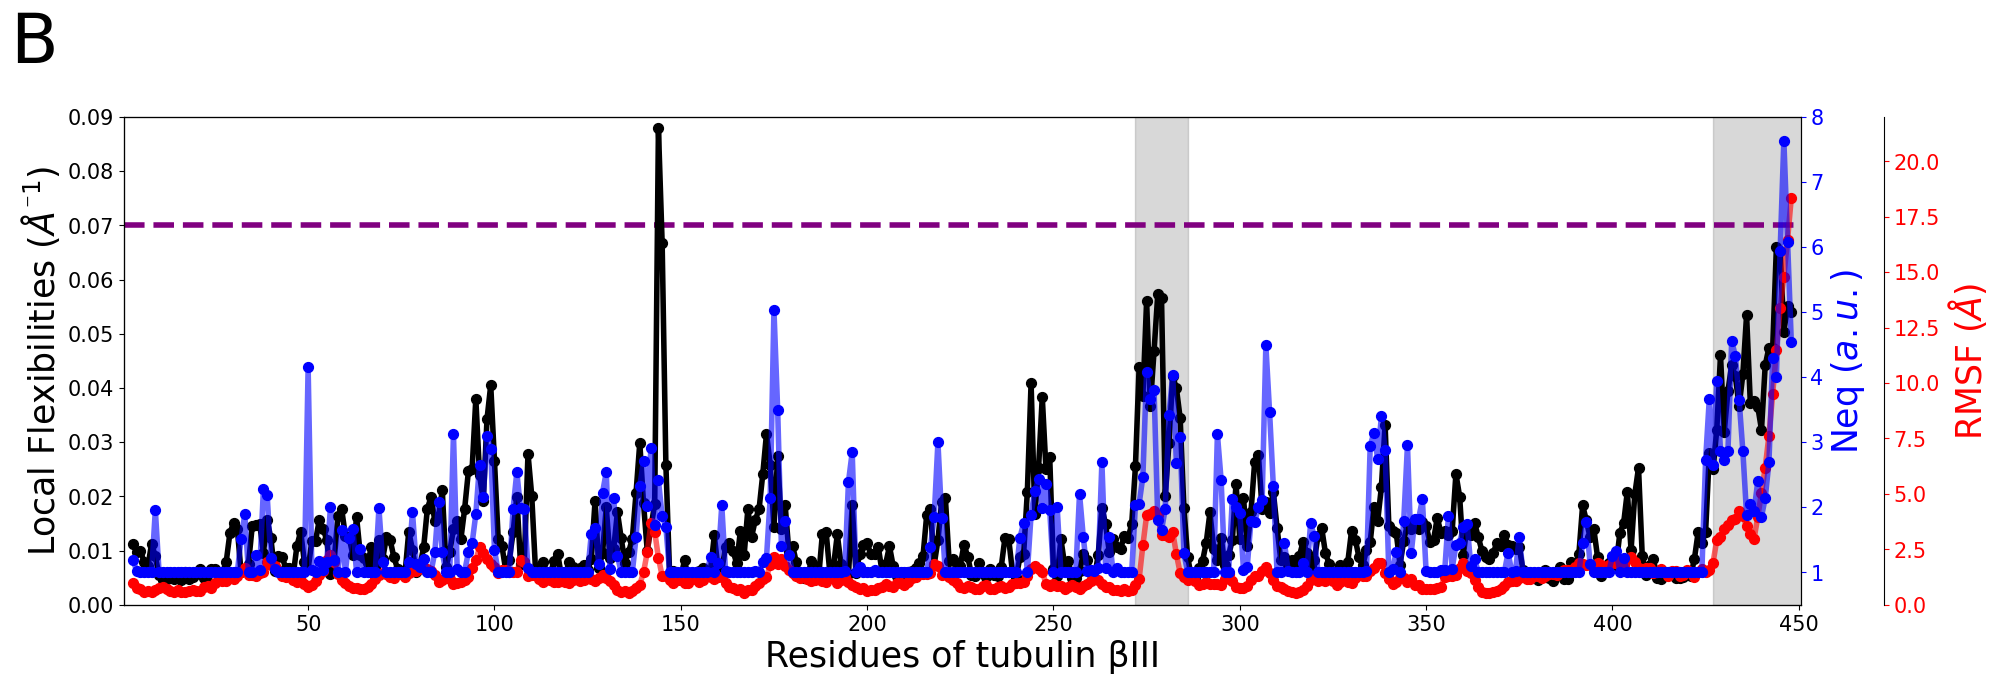

In [38]:
# Plot
fig, ax_LFs = plt.subplots(figsize=size_figure_tuple)

#Create axes so that they share x-axis
ax_RMSF = ax_LFs.twinx()
ax_Neq = ax_LFs.twinx()
plt.xlim(number_first_residue - 0.5, number_last_residue + 0.5)


# Plot data Neq
ax_Neq.scatter(range_residues[spacing:-spacing], neq_by_position[spacing:-spacing], color=color_Neq, s=size_scatter, zorder=1)
ax_Neq.plot(range_residues[spacing:-spacing], neq_by_position[spacing:-spacing], color=color_Neq, linewidth=linewidth, alpha=alpha_line, zorder=1)
ax_Neq.set_ylabel("Neq ($a.u.$)", fontsize=size_ylabel, color=color_Neq)
ax_Neq.set_ylim([0.5, 8])
ax_Neq.tick_params(labelsize=15)
ax_Neq.tick_params(axis='y', colors=color_Neq)

# Plot data RMSF
ax_RMSF.scatter(range_residues[spacing:-spacing], rmsf[spacing:-spacing], color=color_RMSF, s=size_scatter)
ax_RMSF.plot(range_residues[spacing:-spacing], rmsf[spacing:-spacing], color=color_RMSF, linewidth=linewidth, alpha=alpha_line, zorder=5)
ax_RMSF.set_ylabel("RMSF ($Å$)", fontsize=size_ylabel, color=color_RMSF)
ax_RMSF.set_ylim([0.0, 22])
ax_RMSF.spines['right'].set_position(('outward', 60))
ax_RMSF.tick_params(labelsize=15)
ax_RMSF.tick_params(axis='y', colors=color_RMSF)


# Add filling for the zones usually occupied by alpha-helices and beta-sheets
rect_M_loop = patches.Rectangle((272, 0), 14, 0.12, color='grey', alpha=0.3) # Residues 272 to 286
rect_CTT = patches.Rectangle((427, 0), 24, 0.12, color='grey', alpha=0.3) # Residues 427 to 450

ax_LFs.add_patch(rect_M_loop)
ax_LFs.add_patch(rect_CTT)


ax_LFs.set_xlabel(xlabel, fontsize=size_xlabel)
ax_LFs.set_ylabel(ylabel, fontsize=size_ylabel)

# Plot data LFs
ax_LFs.scatter(range_residues[spacing:-spacing], local_flexibilities, color=color_LFs, s=size_scatter, zorder=10)
ax_LFs.plot(range_residues[spacing:-spacing], local_flexibilities, color=color_LFs, linewidth=linewidth, alpha=1.0, zorder=10)
ax_LFs.set_ylim([0.0, 0.09])
ax_LFs.tick_params(labelsize=15)
ax_LFs.tick_params(axis='y', colors=color_LFs) 

# Add a dashed line for the value of LF for a polyalanine
ax_LFs.axhline(y=0.07, color="purple", linestyle='--', linewidth = 4)

# Indicate that this is Figure B
ax_LFs.text(-30, 0.10,"B", fontsize=50)

plt.tight_layout()

plt.savefig("../figures/LFs.svg", dpi=DPI)


In [39]:
import svg_stack as ss

# Create a document and a vertical layout
doc = ss.Document()
layout = ss.VBoxLayout()

# Add the SVG files to the layout
layout.addSVG('../figures/LCs.svg', alignment=ss.AlignCenter)
layout.addSVG('../figures/LFs.svg', alignment=ss.AlignCenter)

# Set the layout and save
doc.setLayout(layout)
doc.save('../figures/LCs_and_LFs.svg')
